# 1 Exploratory Data Analysis  

**Team 1:** John Chen, Mendelina Lopez, and Katie Hu

The focus of this notebook is to do an initial assessment to better understand the data using some light data cleaning and visualizations.
  
<font color = red > **NOTICE:** </font> This study uses Twitter data to detect hate speech and offensive language. The content can be triggering due to the nature of the study with text consisting of racist, homophobic, sexist, and offensive language.
<br>
<br>  
***

#### Import Libraries and Establish Paths to Directory

In [157]:
# Libraries For Exploratory Data Analysis
import os
import sys
import pandas as pd
import numpy as np
import emoji
from nltk.corpus import stopwords
from collections import defaultdict, Counter
from string import punctuation
from wordcloud import WordCloud 
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from tabulate import tabulate
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Set Path to EDA Images
eda_path = '../Image/Exploratory Data Analysis/'

# Read in Data
data = pd.read_csv('../Data/Data_Source.csv', index_col = [0])
data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# Create a copy to leave data source untouched
df = data.copy()

In [9]:
# Gain insight into data types and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


#### Data Ingestion and Pre-Processing

In [14]:
# Change display max width for text
pd.set_option('display.max_colwidth', None)
# Preview a Few Random Tweets
df.tweet.sample(n = 5)

21397                            So far I've only seen 3 bad bitches talkn bout Mansion &#233;lan .. Wtf is up!!
13259                                            My Hawaiian thought of the day, No Aloha for muzzie pigs, EVER!
10518                                                                    I don't trust no bitch ... I dog em out
9784     Got a couple thou den I get a couple shooters Fa dat couple thou mane my niccas will shoot ya &#128591;
8784                                                                                        Crew neck ass nigguh
Name: tweet, dtype: object

In [15]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {'''#{.}!,:@_[]'''}

# Stopwords
sw = stopwords.words("english")

# A function to show our descriptive statistics
def descriptive_stats(tokens, num_words = 5, verbose=True) :
    
    num_tokens = len(tokens)
    num_unique_tokens = len(Counter(tokens).keys())
    lexical_diversity = round((num_unique_tokens/num_tokens),2) # Rounded to 2 Digits to match format
    num_characters = sum(len(i) for i in tokens)
    most_common = Counter(tokens).most_common(num_words)
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The most common tokens are {most_common}.")
        
    return

# Remove stop words
def remove_stop(tokens) :
    tokens = [file for file in tokens if file not in sw]
    return(tokens)

# Remove unnecessary puncuation
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

# Tokenize the given text
def tokenize(text) :  
    text = [file.lower().strip() for file in text.split()]
    return(text)

# Compile text into a pipeline
def prepare(text, pipeline) : 
    tokens = str(text)
    for transform in pipeline : 
        tokens = transform(tokens)
    return(tokens)

In [17]:
# Create a tokenized column with a data cleaning pipeline 
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]
df["tokens"] = df["tweet"].apply(prepare,pipeline=my_pipeline)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tokens
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,"[rt, mayasolovely, woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]"
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,"[rt, mleew17, boy, dats, coldtyga, dwn, bad, cuffin, dat, hoe, 1st, place]"
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,"[rt, urkindofbrand, dawg, rt, 80sbaby4life, ever, fuck, bitch, start, cry, confused, shit]"
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,"[rt, cganderson, vivabased, look, like, tranny]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,"[rt, shenikaroberts, shit, hear, might, true, might, faker, bitch, told, ya, 57361]"


In [19]:
# Create a corpus of all tokenized tweets
tweet_corpus = [x for y in df['tokens'] for x in y]

# Separate Tweets by Hate Speech and Offensive Language
hate_offensive_tweets = df['tokens'].loc[(df['hate_speech'] > 0) & (df['offensive_language'] > 0)]
clean_tweets = df['tokens'].loc[df['neither'] > 0]

# Create a corpus of hate, offensive speech and text that does not contain hate or offensive language
hate_offensive_corpus = [x for y in hate_offensive_tweets for x in y]
clean_corpus = [x for y in clean_tweets for x in y]

In [20]:
# calls to descriptive_stats here
print('''Descriptive Statistics for All Tweets\n''') 
descriptive_stats(tweet_corpus, num_words = 10)

print('''\nDescriptive Statistics for Hate-Related and Offensive-Related Tweets\n''') 
descriptive_stats(hate_offensive_corpus, num_words = 10)

print('''\nDescriptive Statistics for Non-Hate or Offensive-Related Tweets\n''') 
descriptive_stats(clean_corpus, num_words = 10)

Descriptive Statistics for All Tweets

There are 226452 tokens in the data.
There are 40682 unique tokens in the data.
There are 1308809 characters in the data.
The lexical diversity is 0.180 in the data.
The most common tokens are [('bitch', 8120), ('rt', 7578), ('bitches', 3045), ('like', 2759), ('hoes', 2334), ('pussy', 2073), ('im', 2063), ('hoe', 1866), ('dont', 1749), ('ass', 1562)].

Descriptive Statistics for Hate-Related and Offensive-Related Tweets

There are 40801 tokens in the data.
There are 10854 unique tokens in the data.
There are 231538 characters in the data.
The lexical diversity is 0.270 in the data.
The most common tokens are [('bitch', 1330), ('rt', 1186), ('nigga', 594), ('like', 531), ('ass', 472), ('bitches', 451), ('niggas', 410), ('fuck', 406), ('hoes', 382), ('dont', 364)].

Descriptive Statistics for Non-Hate or Offensive-Related Tweets

There are 57074 tokens in the data.
There are 17955 unique tokens in the data.
There are 345524 characters in the data.
T

In [27]:
# Top Most Common Words
total_counts = Counter(tweet_corpus)
words = []
freq = []
for word, count in total_counts.most_common(25):
    words.append(word)
    freq.append(count)
    print('%s: %i' % (word, count))

bitch: 8120
rt: 7578
bitches: 3045
like: 2759
hoes: 2334
pussy: 2073
im: 2063
hoe: 1866
dont: 1749
ass: 1562
get: 1428
fuck: 1406
got: 1289
u: 1272
shit: 1249
nigga: 1191
aint: 1157
trash: 1124
lol: 1033
amp: 839
know: 805
niggas: 787
one: 697
love: 695
cant: 661


#### Exploratory Data Analysis

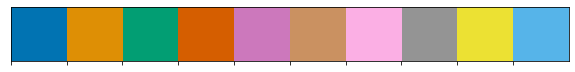

In [194]:
# Set Color Palette to be colorblind friendly
current_palette = sns.color_palette('colorblind')
sns.palplot(sns.color_palette("colorblind"))
plt.show()

In [195]:
current_cmap = list((sns.color_palette("colorblind").as_hex()))
print(current_cmap)

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


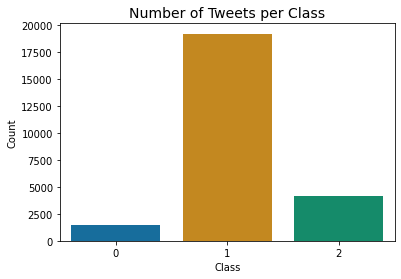

In [79]:
# Count of Class Types
plt.figure(figsize = (6, 4))
sns.countplot(x = 'class', data = df, palette = current_palette)
plt.title('Number of Tweets per Class', fontsize = 14)
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig(eda_path + 'class_count.png')
plt.show()

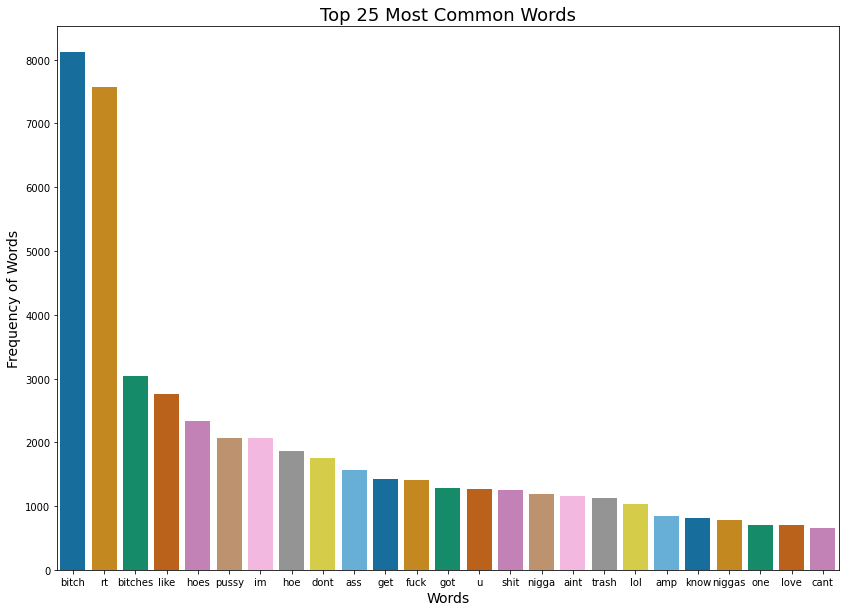

In [80]:
# Top 25 Most Frequently Common Words
plt.figure(figsize = (14, 10))
sns.barplot(x = words, y = freq, palette = current_palette)
plt.title('Top 25 Most Common Words', fontsize=18)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency of Words', fontsize=14)
plt.savefig(eda_path + 'most_common_words.png')
plt.show()


In [103]:
# Count Length of Tweets
df['tweet_length'] = df.tokens.apply(lambda x: len(x))

In [159]:
# Set legend for graph below
custom_lines = [Line2D([0], [0], lw=4, color = '#0173b2'),
                Line2D([0], [0], lw=4, color = '#ca9161'),
                Line2D([0], [0], lw=4, color = '#029e73')]

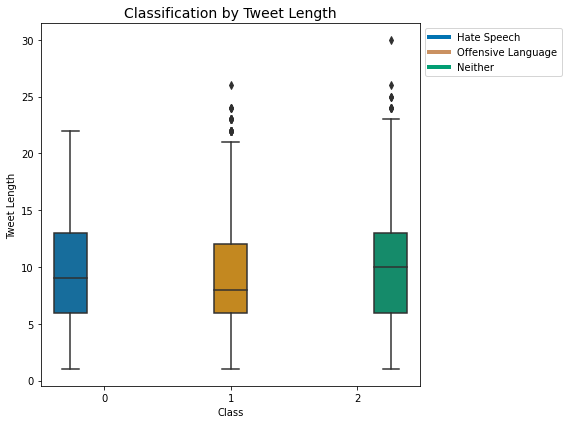

In [160]:
# Identify if hate speech and or offensive language has a higher amount of text in a tweet
plt.figure(figsize = (8, 6))
sns.boxplot(x = 'class', y = 'tweet_length', hue = 'class', data = df, palette = current_palette)
plt.title('Classification by Tweet Length', fontsize = 14)
plt.xlabel('Class')
plt.ylabel('Tweet Length')
plt.legend(custom_lines, ['Hate Speech', 'Offensive Language', 'Neither'], bbox_to_anchor = (1, 1), loc = 'upper left')
plt.savefig(eda_path + 'classification_tweet_length.png')
plt.tight_layout()
plt.show()

Sentiment Analysis

In [253]:
# Clean Tweet Column Itself
clean_tweets = []
for row in df['tweet'] :
    text = " ".join(prepare(row, pipeline = my_pipeline))
    if text :
        clean_tweets.append(text)

# Convert to DataFrame
clean_tweets_df = pd.DataFrame(clean_tweets)
clean_tweets_df.columns = ['tweet_clean']
clean_tweets_df.head()

,tweet_clean
0,rt mayasolovely woman shouldnt complain cleaning house amp man always take trash
1,rt mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place
2,rt urkindofbrand dawg rt 80sbaby4life ever fuck bitch start cry confused shit
3,rt cganderson vivabased look like tranny
4,rt shenikaroberts shit hear might true might faker bitch told ya 57361


In [271]:
# Reset df index to line up correctly with clean_tweets before merge
df = df.reset_index()
df

,index,count,hate_speech,offensive_language,neither,class,tweet,tokens,tweet_length
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,"[rt, mayasolovely, woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]",12
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,"[rt, mleew17, boy, dats, coldtyga, dwn, bad, cuffin, dat, hoe, 1st, place]",12
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,"[rt, urkindofbrand, dawg, rt, 80sbaby4life, ever, fuck, bitch, start, cry, confused, shit]",12
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,"[rt, cganderson, vivabased, look, like, tranny]",6
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,"[rt, shenikaroberts, shit, hear, might, true, might, faker, bitch, told, ya, 57361]",12
...,...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;","[yous, muthafin, lie, 8220lifeasking, 20pearls, coreyemanuel, right, tl, trash, 8230, mine, bible, scriptures, hymns8221]",14
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy","[youve, gone, broke, wrong, heart, baby, drove, redneck, crazy]",9
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again,"[young, buck, wanna, eat, dat, nigguh, like, aint, fuckin, dis]",10
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,"[youu, got, wild, bitches, tellin, lies]",6


In [272]:
clean_tweets_df = pd.DataFrame(clean_tweets_df).join(df['class'])
clean_tweets_df.shape

(24783, 3)

In [273]:
clean_tweets_df

,tweet_clean,sentiment,class
0,rt mayasolovely woman shouldnt complain cleaning house amp man always take trash,0.000000,2
1,rt mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place,-0.700000,1
2,rt urkindofbrand dawg rt 80sbaby4life ever fuck bitch start cry confused shit,-0.333333,1
3,rt cganderson vivabased look like tranny,0.000000,1
4,rt shenikaroberts shit hear might true might faker bitch told ya 57361,0.075000,1
...,...,...,...
24778,yous muthafin lie 8220lifeasking 20pearls coreyemanuel right tl trash 8230 mine bible scriptures hymns8221,0.285714,1
24779,youve gone broke wrong heart baby drove redneck crazy,-0.550000,2
24780,young buck wanna eat dat nigguh like aint fuckin dis,0.100000,1
24781,youu got wild bitches tellin lies,0.100000,1


In [274]:
# Calculating Sentiment Analysis
clean_tweets_df['sentiment'] = clean_tweets_df['tweet_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
clean_tweets_df.head()

,tweet_clean,sentiment,class
0,rt mayasolovely woman shouldnt complain cleaning house amp man always take trash,0.000000,2
1,rt mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place,-0.700000,1
2,rt urkindofbrand dawg rt 80sbaby4life ever fuck bitch start cry confused shit,-0.333333,1
3,rt cganderson vivabased look like tranny,0.000000,1
4,rt shenikaroberts shit hear might true might faker bitch told ya 57361,0.075000,1


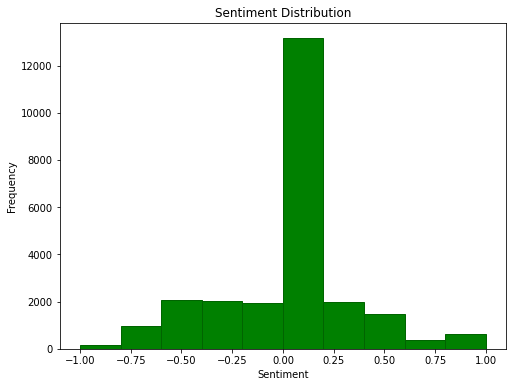

In [275]:
# Plot Sentiment Distribution
plt.figure(figsize = (8, 6))
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(clean_tweets_df['sentiment'], color = 'green', ec = 'darkgreen')
plt.title('Sentiment Distribution')
plt.savefig(eda_path + 'sentiment_distribution.png')
plt.show()

Word Cloud

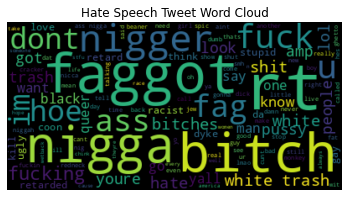

In [276]:
# Separate Text Data for Hate Speech Tweets Only
text_class_0 = ' '.join(clean_tweets_df[clean_tweets_df['class'] == 0]['tweet_clean'])

# Generate Word Cloud for hate tweets
wordcloud_class_0 = WordCloud().generate(text_class_0)
plt.imshow(wordcloud_class_0, interpolation='bilinear')
plt.axis('off')
plt.title('Hate Speech Tweet Word Cloud')
plt.savefig(eda_path + 'hate_word_cloud.png')
plt.show()

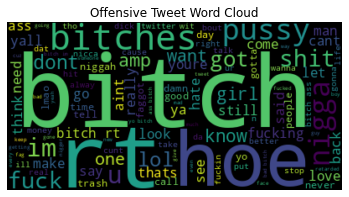

In [277]:
# Create separate text data for offensive tweets

text_class_1 = ' '.join(clean_tweets_df[clean_tweets_df['class'] == 1]['tweet_clean'])

# Generate Word Cloud for offensive tweets
wordcloud_class_1 = WordCloud().generate(text_class_1)
plt.imshow(wordcloud_class_1, interpolation='bilinear')
plt.axis('off')
plt.title('Offensive Tweet Word Cloud')
plt.savefig(eda_path + 'offensive_word_cloud.png')
plt.show()

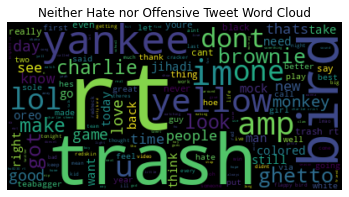

In [278]:
# Create separate text data for offensive tweets and nonoffensive tweets
text_class_2 = ' '.join(clean_tweets_df[clean_tweets_df['class'] == 2]['tweet_clean'])

# Generate Word Cloud for offensive tweets
wordcloud_class_2 = WordCloud().generate(text_class_2)
plt.imshow(wordcloud_class_2, interpolation='bilinear')
plt.axis('off')
plt.title('Neither Hate nor Offensive Tweet Word Cloud')
plt.savefig(eda_path + 'not_hateandoffensive_word_cloud.png')
plt.show()

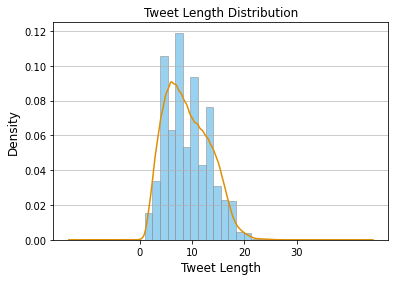

In [279]:
# Density Plot 

clean_tweets_df['tweet_length'] = clean_tweets_df['tweet_clean'].apply(lambda x: len(x.split()))
fig, ax = plt.subplots(figsize=(6, 4))

# Histogram
ax.hist(clean_tweets_df['tweet_length'], bins=20, density=True, color= '#56b4e9', edgecolor='#949494', alpha=.6)

# KDE
clean_tweets_df['tweet_length'].plot(kind='kde', color='#de8f05')

ax.set_title('Tweet Length Distribution', fontsize=16)
ax.set_xlabel('Tweet Length', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.grid(axis='y', alpha=0.8)
ax.set_xticks(range(0, max(df['tweet_length'])+1, 10))
ax.set_xticklabels(range(0, max(df['tweet_length'])+1, 10), fontsize=10)

plt.title('Tweet Length Distribution')
plt.savefig(eda_path + 'tweet_length_density_plot.png')
plt.show()

Save Pre-Processing CSV for Data Preparation

In [283]:
df = df.drop(['index'], axis = 1)
df

,count,hate_speech,offensive_language,neither,class,tweet,tokens,tweet_length
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...,"[rt, mayasolovely, woman, shouldnt, complain, cleaning, house, amp, man, always, take, trash]",12
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!,"[rt, mleew17, boy, dats, coldtyga, dwn, bad, cuffin, dat, hoe, 1st, place]",12
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit,"[rt, urkindofbrand, dawg, rt, 80sbaby4life, ever, fuck, bitch, start, cry, confused, shit]",12
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny,"[rt, cganderson, vivabased, look, like, tranny]",6
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;,"[rt, shenikaroberts, shit, hear, might, true, might, faker, bitch, told, ya, 57361]",12
...,...,...,...,...,...,...,...,...
24778,3,0,2,1,1,"you's a muthaf***in lie &#8220;@LifeAsKing: @20_Pearls @corey_emanuel right! His TL is trash &#8230;. Now, mine? Bible scriptures and hymns&#8221;","[yous, muthafin, lie, 8220lifeasking, 20pearls, coreyemanuel, right, tl, trash, 8230, mine, bible, scriptures, hymns8221]",14
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, and drove me redneck crazy","[youve, gone, broke, wrong, heart, baby, drove, redneck, crazy]",9
24780,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I aint fuckin dis up again,"[young, buck, wanna, eat, dat, nigguh, like, aint, fuckin, dis]",10
24781,6,0,6,0,1,youu got wild bitches tellin you lies,"[youu, got, wild, bitches, tellin, lies]",6


In [284]:
clean_tweets_df

,tweet_clean,sentiment,class,tweet_length
0,rt mayasolovely woman shouldnt complain cleaning house amp man always take trash,0.000000,2,12
1,rt mleew17 boy dats coldtyga dwn bad cuffin dat hoe 1st place,-0.700000,1,12
2,rt urkindofbrand dawg rt 80sbaby4life ever fuck bitch start cry confused shit,-0.333333,1,12
3,rt cganderson vivabased look like tranny,0.000000,1,6
4,rt shenikaroberts shit hear might true might faker bitch told ya 57361,0.075000,1,12
...,...,...,...,...
24778,yous muthafin lie 8220lifeasking 20pearls coreyemanuel right tl trash 8230 mine bible scriptures hymns8221,0.285714,1,14
24779,youve gone broke wrong heart baby drove redneck crazy,-0.550000,2,9
24780,young buck wanna eat dat nigguh like aint fuckin dis,0.100000,1,10
24781,youu got wild bitches tellin lies,0.100000,1,6


In [285]:
# Drop Overlapping columns to join dataframes
clean_tweets_df.drop(['class', 'tweet_length'], axis = 1, inplace = True)
clean_tweets_df.shape

(24783, 2)

In [286]:
# Join Dataframes together for output
df1 = pd.DataFrame(df).join(clean_tweets_df)
df1.shape

(24783, 10)

In [287]:
# Output Data Source of Pre-Processed Data
df1.to_csv('../Data/Pre-Processed_Data.csv')

In [288]:
# Shape Quality Check
print(' There are', df1.shape[0], 'and', df1.shape[1], 'columns in the dataframe.')

 There are 24783 and 10 columns in the dataframe.


In [289]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   count               24783 non-null  int64  
 1   hate_speech         24783 non-null  int64  
 2   offensive_language  24783 non-null  int64  
 3   neither             24783 non-null  int64  
 4   class               24783 non-null  int64  
 5   tweet               24783 non-null  object 
 6   tokens              24783 non-null  object 
 7   tweet_length        24783 non-null  int64  
 8   tweet_clean         24783 non-null  object 
 9   sentiment           24783 non-null  float64
dtypes: float64(1), int64(6), object(3)
memory usage: 1.9+ MB
